In [3]:
%load_ext autoreload
%autoreload 2

from collections import OrderedDict

import GPUtil
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils import *

In [4]:
def set_free_gpu():
    gpus = GPUtil.getGPUs()
    gpu = min(gpus[::-1], key=lambda x: x.load)
    device = jax.devices("gpu")[gpu.id]
    jax.config.update("jax_default_device", device)
    print(f"Default device: GPU {gpu.id} ({gpu.name}) load={gpu.load*100}%")


set_free_gpu()

Default device: GPU 3 (NVIDIA L40S) load=0.0%


# Developpement and tests

## Basic test

In [8]:
params = {
    "N0": 150,
    "N1": 20,
    "lam": 1.0,
    "alpha": jnp.sqrt(4),
    "kappa_2": 1 * MHz,
    "kappa_a": 1 / (100 * us),
    "kappa_phi": 1 / (10 * us),
    "kerr": 200.0 * kHz,
    "T_gate": 40 * ns,
    "Nt": 101,
    "stabilized": False,
    "rho_ctrl_0": 1,
    "rho_target_0": 0,
    "save_states": True,
    "refocus": True,
}
output = simulate_cnot(**params)

|██████████| 100.0% ◆ elapsed 423.64ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 362.08ms ◆ remaining 0.00ms  


(8, 201)


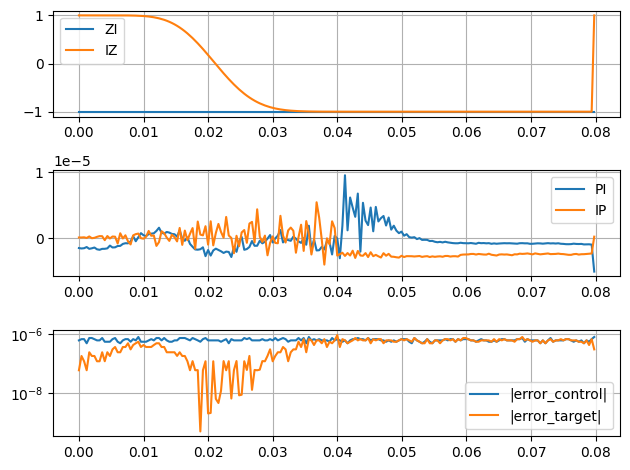

In [9]:
fig, ax = plt.subplots(3)
ax[0].plot(output.tsave, output.expects[0].real, label="ZI")
ax[0].plot(output.tsave, output.expects[1].real, label="IZ")
ax[0].grid()
ax[0].legend()
ax[1].plot(output.tsave, output.expects[2].real, label="PI")
ax[1].plot(output.tsave, output.expects[3].real, label="IP")
ax[1].grid()
ax[1].legend()
ax[2].plot(output.tsave, jnp.abs(output.expects[4] - 1), label="|error_control|")
ax[2].plot(output.tsave, jnp.abs(output.expects[5] - 1), label="|error_target|")
ax[2].grid()
ax[2].legend()
ax[2].set_yscale("log")

fig.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 11.87it/s]


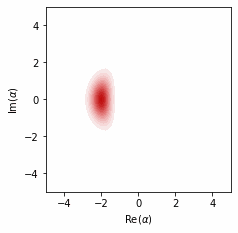

In [10]:
plot_gif(output.states, 0)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 12.45it/s]


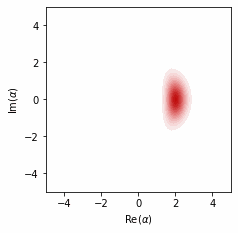

In [11]:
plot_gif(output.states, 1)

## Batching test

In [57]:
alpha = jnp.sqrt(jnp.linspace(2, 6, 5))
params = dict(
    N0=100,
    N1=15,
    lam=0.4,
    alpha=alpha,
    kappa_2=1 * MHz,
    kappa_a=1 / (10 * us),
    kappa_phi=1 / (10 * us),
    kerr=0.0 * kHz,
    T_gate=100 * ns,
    Nt=101,
    stabilized=True,
    rho_ctrl_0=2,
    rho_target_0=2,
    save_states=False,
)
axes_map = {k: None for k in params}
axes_map["alpha"] = 0

output = jax.vmap(lambda params: simulate_cnot(**params), in_axes=(axes_map,))(params)

|██████████| 100.0% ◆ elapsed 207.54ms ◆ remaining 0.00ms 


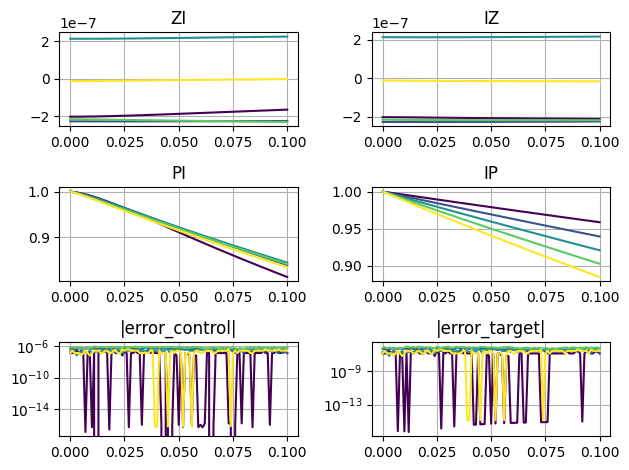

In [58]:
fig, ax = plt.subplots(3, 2)
cmap = plt.get_cmap("viridis")
colors = cmap(jnp.linspace(0, 1, len(alpha)))
for ind, c in enumerate(colors):
    ax[0, 0].plot(output.tsave[ind], output.expects[ind, 0].real.T, c=c)
    ax[0, 1].plot(output.tsave[ind], output.expects[ind, 1].real.T, c=c)

    ax[1, 0].plot(output.tsave[ind], output.expects[ind, 2].real.T, c=c)
    ax[1, 1].plot(output.tsave[ind], output.expects[ind, 3].real.T, c=c)

    ax[2, 0].plot(output.tsave[ind], jnp.abs(output.expects[ind, 4] - 1).T, c=c)
    ax[2, 1].plot(output.tsave[ind], jnp.abs(output.expects[ind, 5] - 1).T, c=c)

    ax[2, 0].set_yscale("log")
    ax[2, 1].set_yscale("log")

for a, t in zip(
    ax.flatten(), ["ZI", "IZ", "PI", "IP", "|error_control|", "|error_target|"]
):
    a.set_title(t)
    a.grid()

fig.tight_layout()
plt.show()

## Fidelity test

In [59]:
params = dict(
    N0=150,
    N1=20,
    lam=0.0,
    alpha=2,
    kappa_2=2 * MHz,
    kappa_a=1 * kHz,
    kappa_phi=0,  # 1 / (10 * us),
    kerr=0.0 * kHz,
    T_gate=500 * ns,
    Nt=101,
    stabilized=True,
)


errors, nbars, tgate = get_error_cnot(params)

|██████████| 100.0% ◆ elapsed 5.43s ◆ remaining 0.00ms  


In [60]:
errors

Array([2.1159649e-06, 1.6361475e-05, 2.4699003e-02, 1.2399554e-02],      dtype=float32)

In [61]:
nbars

Array([3.9973185, 3.9973185], dtype=float32)

In [62]:
tgate

Array(0.5, dtype=float32)

In [66]:
pzc_th = get_pz_from_kappa(
    get_theoretical_gamma_z_control(
        tgate, params["alpha"], params["lam"], params["kappa_a"], params["kappa_2"]
    ),
    tgate,
)
pzc_sim = errors[2]
print(
    f"pz control: theory: {pzc_th:.2e}, simu: {pzc_sim:.2e}, diff: {pzc_th - pzc_sim:.2e}"
)

pz control: theory: 2.42e-02, simu: 2.47e-02, diff: -4.68e-04


In [68]:
pzt_th = get_pz_from_kappa(
    get_theoretical_gamma_z_target(params["alpha"], params["kappa_a"]), tgate
)
pzt_sim = errors[3]
print(
    f"pz target: theory: {pzt_th:.2e}, simu: {pzt_sim:.2e}, diff: {pzt_th - pzt_sim:.2e}"
)

pz target: theory: 1.24e-02, simu: 1.24e-02, diff: 1.02e-05


# Sweep gate time

In [7]:
max_batch_size = 50
params = dict(
    N0=100,
    N1=20,
    kappa_2=1 * MHz,
    kappa_a=20 * kHz,
    kappa_phi=0 * kHz,
    kerr=0 * kHz,
    T_gate=0 * ns,
    Nt=101,
    stabilized=False,
)

lambdas = jnp.linspace(0, 1.0, 3)
alphas = jnp.sqrt(jnp.linspace(2, 10, 11))
sweep_params = OrderedDict(
    alpha=alphas,
    lam=lambdas,
)
errors, nbars, tgates = batch_cnot_errors(
    params, sweep_params, max_batch_size, cathesian_batching=True
)

1 batches.


|██████████| 100.0% ◆ elapsed 21.09s ◆ remaining 0.00ms  


1/1 | elapsed time = 0:00:27 | time per batch = 0:00:27 | time to end = 0:00:00


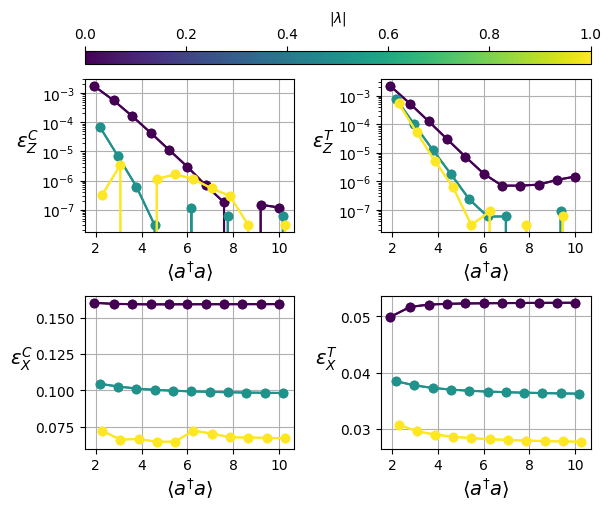

In [8]:
fig = plt.figure(layout="constrained", figsize=(6, 5))
gs = fig.add_gridspec(2, 2, wspace=0.06, hspace=0.05)
ax = gs.subplots()
cmap = plt.get_cmap("viridis")
colors = cmap(jnp.linspace(0, 1, len(lambdas)))
errors_name = [f"$\\epsilon_{op}^{cat}$" for op in ["Z", "X"] for cat in ["C", "T"]]
for a, data, title in zip(ax.flatten(), jnp.moveaxis(errors, -1, 0), errors_name):
    a.set_ylabel(title, rotation=0, labelpad=10, fontsize=14)
    a.set_xlabel(r"$\langle a^\dag a\rangle$", labelpad=2, fontsize=14)
    a.grid()
    for ind_lg, (nbar, sub_d) in enumerate(zip(nbars, data)):
        a.plot(nbar, sub_d, "o-", c=colors[ind_lg])
for a in ax[0]:
    a.set_yscale("log")

c_norm = mpl.colors.Normalize(vmin=jnp.min(lambdas), vmax=jnp.max(lambdas))
s_map = mpl.cm.ScalarMappable(cmap=cmap, norm=c_norm)
fig.colorbar(
    s_map,
    ax=ax[0],
    label=r"$|\lambda|$",
    orientation="horizontal",
    location="top",
    pad=0.1,
    aspect=40,
)
plt.show()

In [36]:
max_batch_size = 50
params = dict(
    N0=100,
    N1=25,
    # alpha = 2,
    lam=0.4,
    kappa_2=1 * MHz,
    kappa_a=1 / (40 * us),
    kappa_phi=1 / (40 * us),
    kerr=20 * kHz,
    T_gate=-1,  # 200 * ns,
    Nt=101,
    # stabilized = False,
)

alphas = jnp.sqrt(jnp.linspace(2, 10, 11))
sweep_params = OrderedDict(alpha=alphas, stabilized=jnp.array([True, False]))
errors, nbars, tgates = batch_cnot_errors(
    params, sweep_params, max_batch_size, cathesian_batching=True
)

1 batches.


|██████████| 100.0% ◆ elapsed 54.04s ◆ remaining 0.00ms

1/1 | elapsed time = 0:00:54 | time per batch = 0:00:54 | time to end = 0:00:00


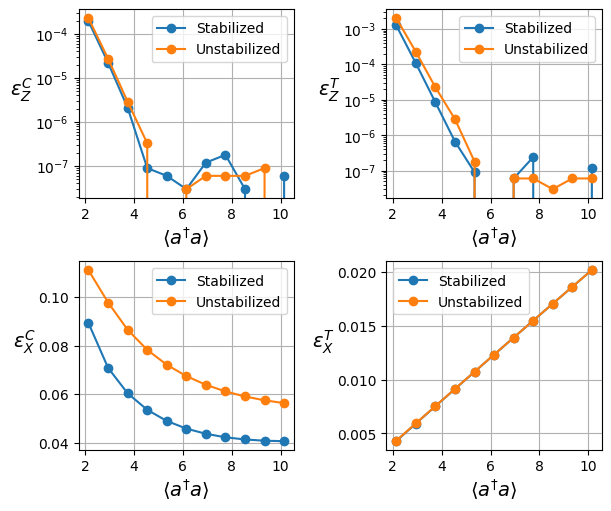

In [37]:
fig = plt.figure(layout="constrained", figsize=(6, 5))
gs = fig.add_gridspec(2, 2, wspace=0.06, hspace=0.05)
ax = gs.subplots()
errors_name = [f"$\\epsilon_{op}^{cat}$" for op in ["Z", "X"] for cat in ["C", "T"]]
for a, data, title in zip(ax.flatten(), jnp.moveaxis(errors, -1, 0), errors_name):
    a.set_ylabel(title, rotation=0, labelpad=10, fontsize=14)
    a.set_xlabel(r"$\langle a^\dag a\rangle$", labelpad=2, fontsize=14)
    a.grid()
    for ind_stab, (nbar, sub_d, lab) in enumerate(
        zip(nbars, data, ["Stabilized", "Unstabilized"])
    ):
        a.plot(nbar[:, 0], sub_d, "o-", label=lab)
    a.legend()
for a in ax[0]:
    a.set_yscale("log")
plt.show()

# Maps of Moon cat performances

## 4 photons

### $\lambda \in \{0, 0.5, 1.\}$, gate in $(\kappa_2(1+\lambda))^{-1}$, $\kappa_a/\kappa_2$ from $10^{-3}$ to $10^{-1}$, $K_4 = 0$ and $\kappa_\phi = 0$

In [25]:
max_batch_size = 100
params = {
    "N0": 100,
    "N1": 20,
    "alpha": 2,
    "kappa_2": 1 * MHz,
    # kappa_a = 1 * KHz,
    "kappa_phi": 0 * kHz,
    "kerr": 0 * kHz,
    "T_gate": 1/(1 * MHz),  # 0 * ns,
    "Nt": 101,
    # "stabilized": False,
}

lambdas = jnp.linspace(0, 1.0, 3)
kappa_a_o_kappa_2 = jnp.geomspace(1e-3, 1e-1, 11)
kappa_a = kappa_a_o_kappa_2 * params["kappa_2"]
stabilized = jnp.array([True, False])
sweep_params = OrderedDict(lam=lambdas, kappa_a=kappa_a, stabilized=stabilized)
errors, nbars, tgates = batch_cnot_errors(
    params, sweep_params, max_batch_size, cathesian_batching=True
)

1 batches.


|██████████| 100.0% ◆ elapsed 01m01s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 01m04s ◆ remaining 0.00ms  

1/1 | elapsed time = 0:02:05 | time per batch = 0:02:05 | time to end = 0:00:00


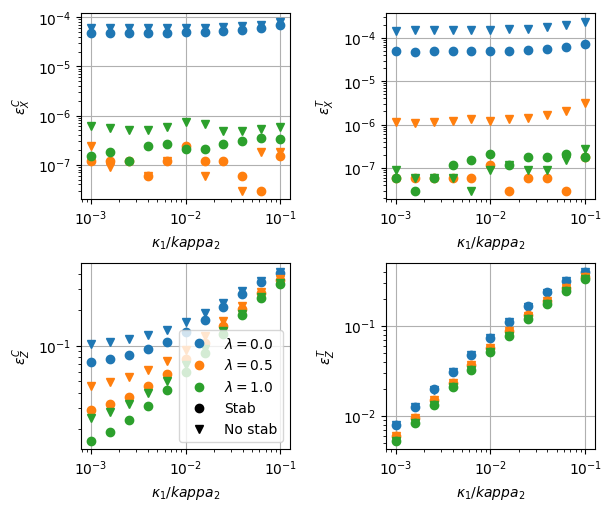

In [26]:
fig = plt.figure(layout="constrained", figsize=(6, 5))
gs = fig.add_gridspec(2, 2, wspace=0.06, hspace=0.05)
ax = gs.subplots()
errors_name = [f"$\\epsilon_{op}^{cat}$" for op in ["X", "Z"] for cat in ["C", "T"]]
for a, data, title in zip(
    ax.flatten(), jnp.moveaxis(jnp.abs(errors), -1, 0), errors_name
):
    a.set_ylabel(title)
    a.set_xlabel(r"$\kappa_1/\kappa_2$")
    for ind_lam, color_lam in enumerate([f"C{i}" for i in range(len(lambdas))]):
        for ind_stab, maker in enumerate(["o", "v"]):
            a.plot(kappa_a_o_kappa_2, data[ind_lam, :, ind_stab], f"{color_lam}{maker}")
    if a == ax[1, 0]:
        for ind in range(len(lambdas)):
            a.plot([], [], f"C{ind}o", label=f"$\\lambda = {lambdas[ind]}$")
        a.plot([], [], "ko", label="Stab")
        a.plot([], [], "kv", label="No stab")
        a.legend()
    if a in ax[0, :]:
        a.set_yscale("log")
    if a in ax[1, :]:
        a.set_yscale("log")
    a.set_xscale("log")
    a.grid()
plt.show()

In [27]:
max_batch_size = 100
params = {
    "N0": 100,
    "N1": 20,
    "alpha": 2,
    "kappa_2": 1 * MHz,
    # kappa_a = 1 * KHz,
    "kappa_phi": 0 * kHz,
    "kerr": 0 * kHz,
    "T_gate": -1,  # 0 * ns,
    "Nt": 101,
    # "stabilized": False,
}

lambdas = jnp.linspace(0, 1.0, 3)
kappa_a_o_kappa_2 = jnp.geomspace(1e-3, 1e-1, 11)
kappa_a = kappa_a_o_kappa_2 * params["kappa_2"]
stabilized = jnp.array([True, False])
sweep_params = OrderedDict(lam=lambdas, kappa_a=kappa_a, stabilized=stabilized)
errors, nbars, tgates = batch_cnot_errors(
    params, sweep_params, max_batch_size, cathesian_batching=True
)

1 batches.


|██████████| 100.0% ◆ elapsed 01m02s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 01m04s ◆ remaining 0.00ms  

1/1 | elapsed time = 0:02:05 | time per batch = 0:02:05 | time to end = 0:00:00


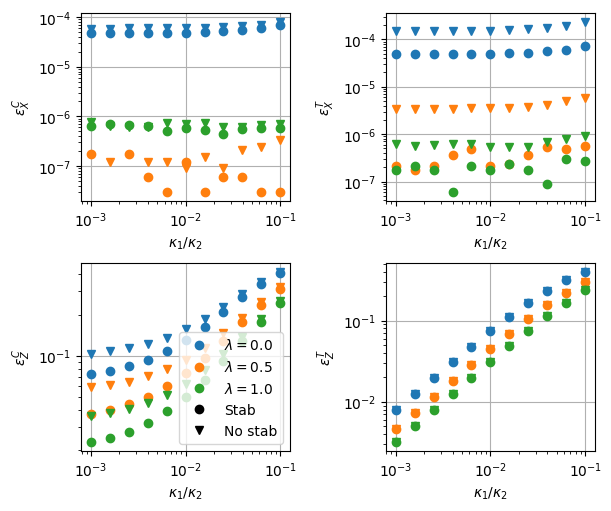

In [29]:
fig = plt.figure(layout="constrained", figsize=(6, 5))
gs = fig.add_gridspec(2, 2, wspace=0.06, hspace=0.05)
ax = gs.subplots()
errors_name = [f"$\\epsilon_{op}^{cat}$" for op in ["X", "Z"] for cat in ["C", "T"]]
for a, data, title in zip(
    ax.flatten(), jnp.moveaxis(jnp.abs(errors), -1, 0), errors_name
):
    a.set_ylabel(title)
    a.set_xlabel(r"$\kappa_1/\kappa_2$")
    for ind_lam, color_lam in enumerate([f"C{i}" for i in range(len(lambdas))]):
        for ind_stab, maker in enumerate(["o", "v"]):
            a.plot(kappa_a_o_kappa_2, data[ind_lam, :, ind_stab], f"{color_lam}{maker}")
    if a == ax[1, 0]:
        for ind in range(len(lambdas)):
            a.plot([], [], f"C{ind}o", label=f"$\\lambda = {lambdas[ind]}$")
        a.plot([], [], "ko", label="Stab")
        a.plot([], [], "kv", label="No stab")
        a.legend()
    if a in ax[0, :]:
        a.set_yscale("log")
    if a in ax[1, :]:
        a.set_yscale("log")
    a.set_xscale("log")
    a.grid()
plt.show()

### $\lambda \in \{0, 0.5, 1.\}$, gate in $(\kappa_2(1+\lambda))^{-1}$, $K_4/\kappa_2$ from $10^{-3}$ to $10^{-1}$, $\kappa_1 = 0$ and $\kappa_\phi = 0$

In [7]:
max_batch_size = 100
params = {
    "N0": 100,
    "N1": 20,
    "alpha": 2,
    "kappa_2": 1 * MHz,
    "kappa_a": 0 * kHz,
    "kappa_phi": 0 * kHz,
    # "kerr": 0 * kHz,
    "T_gate": 1/(1 * MHz),  # 0 * ns,
    "Nt": 101,
    # "stabilized": False,
}

lambdas = jnp.array([0, 0.5, 1.0])
kerr_o_kappa_2 = jnp.geomspace(1e-3, 1e-1, 11)
kerr = kerr_o_kappa_2 * params["kappa_2"]
stabilized = jnp.array([True, False])
sweep_params = OrderedDict(lam=lambdas, kerr=kerr, stabilized=stabilized)
errors, nbars, tgates = batch_cnot_errors(
    params, sweep_params, max_batch_size, cathesian_batching=True
)

1 batches.


|██████████| 100.0% ◆ elapsed 59.01s ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 01m01s ◆ remaining 0.00ms

1/1 | elapsed time = 0:02:00 | time per batch = 0:02:00 | time to end = 0:00:00


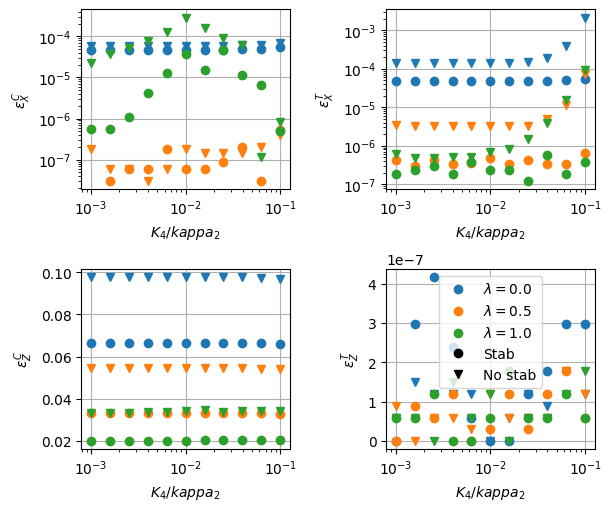

In [8]:
fig = plt.figure(layout="constrained", figsize=(6, 5))
gs = fig.add_gridspec(2, 2, wspace=0.06, hspace=0.05)
ax = gs.subplots()
errors_name = [f"$\\epsilon_{op}^{cat}$" for op in ["X", "Z"] for cat in ["C", "T"]]
for a, data, title in zip(
    ax.flatten(), jnp.moveaxis(jnp.abs(errors), -1, 0), errors_name
):
    a.set_ylabel(title)
    a.set_xlabel(r"$K_4/kappa_2$")
    for ind_lam, color_lam in enumerate([f"C{i}" for i in range(len(lambdas))]):
        for ind_stab, maker in enumerate(["o", "v"]):
            a.plot(kerr_o_kappa_2, data[ind_lam, :, ind_stab], f"{color_lam}{maker}")
    if a == ax[1, 1]:
        for ind in range(len(lambdas)):
            a.plot([], [], f"C{ind}o", label=f"$\\lambda = {lambdas[ind]}$")
        a.plot([], [], "ko", label="Stab")
        a.plot([], [], "kv", label="No stab")
        a.legend()
    a.set_xscale("log")
    if a in ax[0, :]:
        a.set_yscale("log")
    a.grid()
plt.show()

### $\lambda \in \{0, 0.5, 1.\}$, gate in $(\kappa_2(1+\lambda))^{-1}$, $\kappa_\phi/\kappa_2$ from $10^{-3}$ to $10^{-1}$, $\kappa_1 = 0$ and $K_4 = 0$

In [21]:
max_batch_size = 100
params = {
    "N0": 100,
    "N1": 20,
    "alpha": 2,
    "kappa_2": 1 * MHz,
    "kappa_a": 0 * kHz,
    # "kappa_phi": 0 * kHz,
    "kerr": 0 * kHz,
    "T_gate": 1/(1 * MHz),  # 0 * ns,
    "Nt": 101,
    # "stabilized": False,
}

lambdas = jnp.array([0, 0.5, 1.0])
kappa_phi_o_kappa_2 = jnp.geomspace(1e-3, 1e-1, 11)
kappa_phi = kappa_phi_o_kappa_2 * params["kappa_2"]
stabilized = jnp.array([True, False])
sweep_params = OrderedDict(lam=lambdas, kappa_phi=kappa_phi, stabilized=stabilized)
errors, nbars, tgates = batch_cnot_errors(
    params, sweep_params, max_batch_size, cathesian_batching=True
)

1 batches.


|██████████| 100.0% ◆ elapsed 01m02s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 01m04s ◆ remaining 0.00ms  

1/1 | elapsed time = 0:02:06 | time per batch = 0:02:06 | time to end = 0:00:00


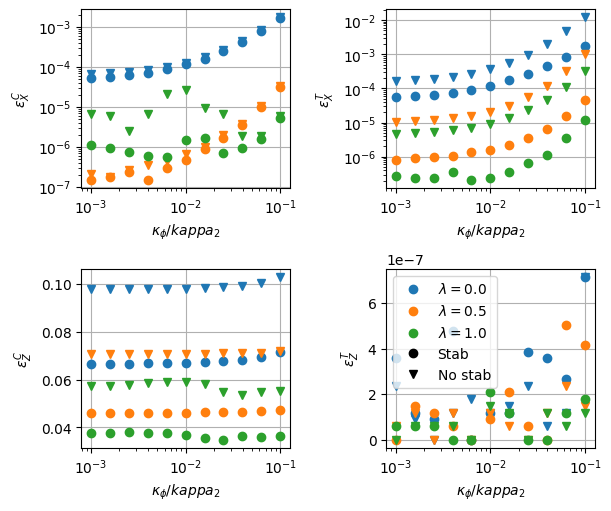

In [22]:
fig = plt.figure(layout="constrained", figsize=(6, 5))
gs = fig.add_gridspec(2, 2, wspace=0.06, hspace=0.05)
ax = gs.subplots()
errors_name = [f"$\\epsilon_{op}^{cat}$" for op in ["X", "Z"] for cat in ["C", "T"]]
for a, data, title in zip(
    ax.flatten(), jnp.moveaxis(jnp.abs(errors), -1, 0), errors_name
):
    a.set_ylabel(title)
    a.set_xlabel(r"$\kappa_\phi/kappa_2$")
    for ind_lam, color_lam in enumerate([f"C{i}" for i in range(len(lambdas))]):
        for ind_stab, maker in enumerate(["o", "v"]):
            a.plot(kappa_a_o_kappa_2, data[ind_lam, :, ind_stab], f"{color_lam}{maker}")
    if a == ax[1, 1]:
        for ind in range(len(lambdas)):
            a.plot([], [], f"C{ind}o", label=f"$\\lambda = {lambdas[ind]}$")
        a.plot([], [], "ko", label="Stab")
        a.plot([], [], "kv", label="No stab")
        a.legend()
    a.set_xscale("log")
    if a in ax[0, :]:
        a.set_yscale("log")
    a.grid()
plt.show()